# Python Tensorflow Tutorial

## Import Libraries

In [1]:
import IPython
import IPython.display
import collections
import copy
# import datetime
import importlib
import itertools
import json
import os
import pathlib
import random
import sys
import tarfile
import urllib.request
import zipfile

from datetime import datetime
from os.path import exists
from packaging import version
from pathlib import Path
from urllib.parse import urlparse
from zipfile import ZipFile

import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf

from keras import Sequential, layers, models, regularizers
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPool2D, TextVectorization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory, text_dataset_from_directory, img_to_array, load_img, plot_model
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from tensorflow import keras  # note - maybe this should be imported differently
from tensorflow.keras import utils
from sklearn.metrics import r2_score

import os, sys, pathlib
from pathlib import Path

## Utility Functions and Plotting Routines

### Plotting Routines

In [2]:
def plot_all_history_metrics(history, title=None):
  """
  Plot all history metrics as a function of epochs

  Args:
    history (tf.keras.callbacks.History | pd.core.frame.DataFrame):
      history obj can of type:
        1) be returned from model fitting
        2) pandas (model history saved as a csv and imported as a DataFrame)
    title (str|None):
      figure title

  """
  # Extract history as dict and convert to dataframe if necessary
  if isinstance(history, tf.keras.callbacks.History):
    history = history.history
  if not isinstance(history, pd.core.frame.DataFrame):
    history = pd.DataFrame(history)

  history.plot()
  plt.ylabel("metrics")
  plt.xlabel("epochs")
  if title:
    plt.title(title)
  plt.show()

In [3]:
def plot_loss_and_mae(history, title=""):
  """
  Plots loss and mae for training and validation data as separate figures.

  Args:
    history:
      history obj can of type:
        1) be returned from model fitting
        2) pandas (model history saved as a csv and imported as a DataFrame)
        3) dictionary
    title (str): Optional caption to include with figure title
  """
  # Extract history dictionary from callback or dataframe if necessary
  if isinstance(history, tf.keras.callbacks.History):
    history = history.history
  elif isinstance(history, pd.core.frame.DataFrame):
    history = history.to_dict('list')

  loss = history['loss']
  val_loss = history['val_loss']

  mae = history['mae']
  val_mae = history['val_mae']

  epochs = range(len(history['loss']))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss: ' + title)
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, mae, label='training_mae')
  plt.plot(epochs, val_mae, label='val_mae')
  plt.title('mae: ' + title)
  plt.xlabel('Epochs')
  plt.legend()

In [4]:
def scatter_plot(x, 
                 y, 
                 xlabel="actual",
                 ylabel="predicted",
                 title="Actual vs Predicted",
                 ):
    """Scatter plot of model predicted vs actual values"""
    x = np.squeeze(x)
    y = np.squeeze(y)
    max_value = max(max(x), max(y))
    plt.scatter(x, y)
    plt.plot([0, max_value], [0, max_value], color='red', linestyle='-', ms = 0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.axis('square')

In [5]:
def error_diagnostics(y_train_actual, 
                      y_train_pred,
                      y_test_actual, 
                      y_test_pred,
                      model_description="",
                      ):
    print(f"Performance of: {model_description}")
    mae_train = keras.losses.mean_absolute_error(np.squeeze(y_train_actual), np.squeeze(y_train_pred))
    mae_test = keras.losses.mean_absolute_error(np.squeeze(y_test_actual), np.squeeze(y_test_pred))
    mse_train = keras.losses.mean_squared_error(np.squeeze(y_train_actual), np.squeeze(y_train_pred))
    mse_test = keras.losses.mean_squared_error(np.squeeze(y_test_actual), np.squeeze(y_test_pred))
    print(f"Mean Average Error Score Training Data: {mae_train}")
    print(f"Mean Average Error Score Testing Data: {mae_test}")
    print(f"Mean Squared Error Score Training Data: {mse_train}")
    print(f"Mean Squared Error Score Testing Data: {mse_test}")    

In [6]:
def plot_model_summary(model):
  """
  Plot kera model layer information.

  Example Usage:
    import IPython.display
    fig = plot_model_summary(model_1)
    IPython.display.display(fig)
  """
  model.summary()
  fig = plot_model(model, show_shapes=True)
  return fig

## Read in Sample Data and Clean Data for Modeling
Example data is actual CARB data used to try and predict PM 2.5 concentrations based on site data.
Key data collected include lat/long, planetary boundary layer (PBL) height, temperature, distance to highway, etc.

We must clean this data so that it can be input into a standard ML model

### Read in CSV into DataFrame

In [7]:
# Read in the pm2.5 dataset
file_name = "https://tonyserver.github.io/misc/pm_25_data_01.csv"
pm_df_csv = pd.read_csv(file_name)

### DataFrame Diagnostics
Around 50,000 data points

In [8]:
display(pm_df_csv)
# pm_df_csv.head()
# pm_df_csv.tail()

,Unnamed: 0,X,sitename,longitude,latitude,date,PBLHeight,Temp,AOD,AADT,distance_to_highway,distance_to_coastline,elevation,percent_impervious,year,month,pm_2.5,season,season_numeric
0,1,1,Agua Tibia,-116.971457,33.463644,20210110,374.086670,0.130649,0.049555,0.0,9833.754,49629.011,486.532257,8.000000,2021,1,0.000000,Winter,1
1,2,2,Agua Tibia,-116.971457,33.463644,20210116,454.416565,3.160924,0.036703,0.0,9833.754,49629.011,486.532257,8.000000,2021,1,1.256910,Winter,1
2,3,3,Agua Tibia,-116.971457,33.463644,20210122,328.770782,6.934329,0.249622,0.0,9833.754,49629.011,486.532257,8.000000,2021,1,3.061840,Winter,1
3,5,5,Agua Tibia,-116.971457,33.463644,20210128,422.876221,2.743084,0.055767,0.0,9833.754,49629.011,486.532257,8.000000,2021,1,2.366190,Winter,1
4,6,6,Agua Tibia,-116.971457,33.463644,20210131,780.964417,5.058250,0.040109,0.0,9833.754,49629.011,486.532257,8.000000,2021,1,0.852330,Winter,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52515,77010,77010,Yuba City-Almond Street,-121.618549,39.138773,20211127,512.312622,8.591341,0.093526,135500.0,195.992,149404.352,18.345465,70.549312,2021,11,22.333333,Fall,4
52516,77011,77011,Yuba City-Almond Street,-121.618549,39.138773,20211128,199.310074,4.080392,0.088279,135500.0,195.992,149404.352,18.345465,70.549312,2021,11,24.860870,Fall,4
52517,77012,77012,Yuba City-Almond Street,-121.618549,39.138773,20211129,197.674835,9.930441,0.098179,135500.0,195.992,149404.352,18.345465,70.549312,2021,11,24.730435,Fall,4
52518,77013,77013,Yuba City-Almond Street,-121.618549,39.138773,20211130,279.907227,7.799436,0.111928,135500.0,195.992,149404.352,18.345465,70.549312,2021,11,24.214583,Fall,4


In [9]:
pm_df_csv.info()
print(f"\ncolumns: {pm_df_csv.columns}")
print(f"\nshape: {pm_df_csv.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52520 entries, 0 to 52519
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             52520 non-null  int64  
 1   X                      52520 non-null  int64  
 2   sitename               52520 non-null  object 
 3   longitude              52520 non-null  float64
 4   latitude               52520 non-null  float64
 5   date                   52520 non-null  int64  
 6   PBLHeight              52520 non-null  float64
 7   Temp                   52520 non-null  float64
 8   AOD                    52520 non-null  float64
 9   AADT                   52520 non-null  float64
 10  distance_to_highway    52520 non-null  float64
 11  distance_to_coastline  52520 non-null  float64
 12  elevation              52520 non-null  float64
 13  percent_impervious     52520 non-null  float64
 14  year                   52520 non-null  int64  
 15  mo

### Visualize and get a feel for the input data and target output

In [10]:
pm_df_csv.describe()

,Unnamed: 0,X,longitude,latitude,date,PBLHeight,Temp,AOD,AADT,distance_to_highway,distance_to_coastline,elevation,percent_impervious,year,month,pm_2.5,season_numeric
count,52520.000000,52520.000000,52520.000000,52520.000000,5.252000e+04,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000,52520.000000
mean,38480.297982,38480.297982,-119.878896,36.287704,2.021468e+07,566.832407,15.890843,0.152438,49818.997604,2166.157995,83038.208939,330.510747,51.920367,2021.403161,6.348420,9.909251,2.679836
std,22273.712605,22273.712605,1.976492,2.237649,4.917587e+03,207.803985,10.216943,0.262033,85665.510488,5962.388996,74232.091214,475.521052,18.687126,0.490537,3.061936,12.877705,1.029224
min,1.000000,1.000000,-124.203470,32.578160,2.021010e+07,23.728403,-24.106941,0.000000,0.000000,11.806000,2311.558000,-32.933838,2.274648,2021.000000,1.000000,-0.944444,1.000000
25%,19106.750000,19106.750000,-121.618549,34.210169,2.021060e+07,417.639015,8.360554,0.072559,0.000000,140.227000,21530.812000,28.976351,38.669565,2021.000000,4.000000,4.875000,2.000000
50%,39013.500000,39013.500000,-120.034203,36.481870,2.021100e+07,548.227661,17.682138,0.107782,5300.000000,383.151000,52581.820000,118.877434,53.657895,2021.000000,6.000000,7.700000,3.000000
75%,57856.500000,57856.500000,-118.171019,37.950741,2.022052e+07,695.407364,24.459202,0.155888,66000.000000,923.136000,129860.931000,407.486237,66.327606,2022.000000,9.000000,11.625000,4.000000
max,77044.000000,77044.000000,-115.483070,41.756130,2.022123e+07,1970.053101,34.991749,4.336686,471000.000000,43325.505000,307644.811000,2561.881592,89.678899,2022.000000,12.000000,685.545455,4.000000


array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'X'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'PBLHeight'}>,
        <Axes: title={'center': 'Temp'}>,
        <Axes: title={'center': 'AOD'}>],
       [<Axes: title={'center': 'AADT'}>,
        <Axes: title={'center': 'distance_to_highway'}>,
        <Axes: title={'center': 'distance_to_coastline'}>,
        <Axes: title={'center': 'elevation'}>],
       [<Axes: title={'center': 'percent_impervious'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'pm_2.5'}>],
       [<Axes: title={'center': 'season_numeric'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

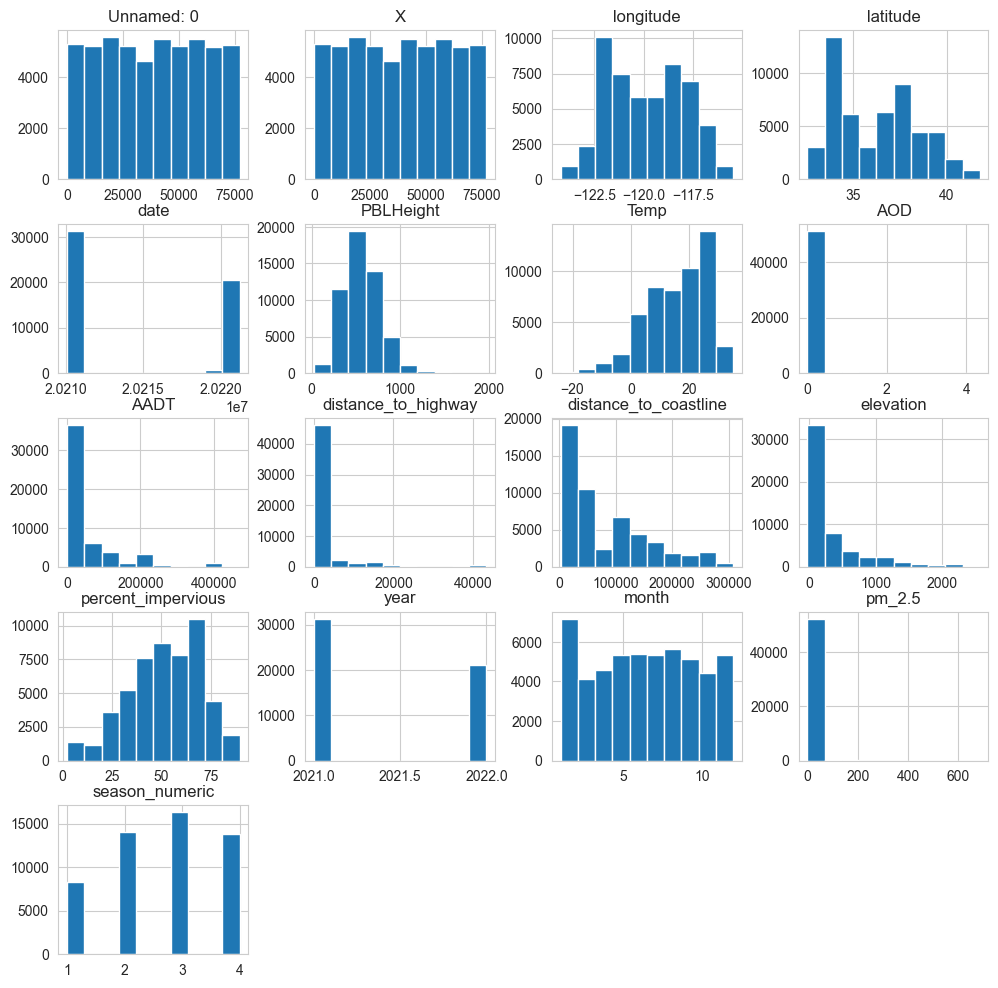

In [11]:
pm_df_csv.hist(figsize=(12, 12))

### Inspect PM 2.5 More closely

Looks like the PM 2.5 visualization is dominated by a few wildfire related measurements.

Annual Standard.   In February 2024, U.S. EPA lowered the federal primary PM2.5 annual standard from 12.0 ug/m3 to 9.0 ug/m3; the secondary annual standard remained at 15 ug/m3.  Current area designation information can be found on U.S. EPA's website.

24-Hour Standard.  In December 2006, U.S. EPA lowered the federal 24-hour PM2.5 standard from 65 ug/m3 to 35 ug/m3; the secondary 24-hour standard is the same as the primary.  Current area designation information can be found on U.S. EPA's website.

<Axes: title={'center': 'pm_2.5 distribution'}, xlabel='pm_2.5', ylabel='count'>

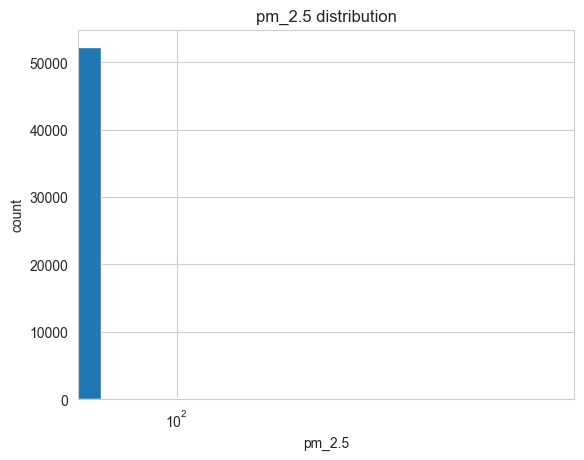

In [12]:
pm_df_csv['pm_2.5'].plot(kind='hist', logx=True, title='pm_2.5 distribution', xlabel='pm_2.5', ylabel='count')

In [13]:
pm_25 = pm_df_csv['pm_2.5'].to_numpy()
pm_25 = np.sort(pm_25)
print(pm_25[-100:])

[109.75       109.79166667 110.16666667 111.125      111.625
 111.625      111.66666667 111.95833333 112.08333333 113.04166667
 113.625      114.25       116.         116.04166667 116.625
 118.125      118.5        118.5        118.79166667 119.22727273
 119.33333333 120.625      126.5        127.29166667 128.45833333
 130.5        131.08333333 134.29166667 134.5        134.69565217
 136.25       137.45833333 138.16666667 140.70833333 140.79166667
 141.16666667 144.75       144.91666667 145.25       146.95833368
 147.04166667 148.16666667 150.33333333 151.20833333 152.54166667
 154.         155.45454545 157.41666667 157.60869565 158.625
 159.59090909 161.90833275 162.25       162.96765137 165.34782609
 167.54166667 171.375      172.45833333 174.65833378 176.41666667
 177.125      178.         178.08333333 178.625      180.54166667
 180.83333333 181.75       182.54166667 186.875      190.45833333
 195.83333333 195.91666667 205.16666667 205.375      215.71428571
 227.54545455 230.9583333

#### Filter out measurement above a threshold (removes fire data)

In [14]:
threshold = 100
print(f"Removing pm 2.5 measurements that are greater than {threshold}")
pm_df = pm_df_csv[pm_df_csv['pm_2.5']< threshold]

Removing pm 2.5 measurements that are greater than 100


<Axes: ylabel='Frequency'>

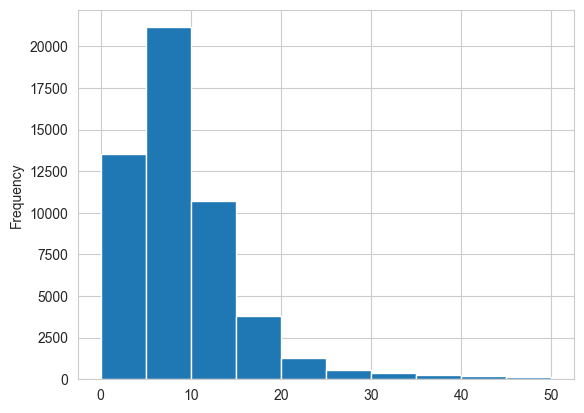

In [15]:
pm_df['pm_2.5'].plot(kind='hist', range=[0, 50])

## Create input and output suitable for TF modeling

In [16]:
columns_numeric = ['longitude', 'latitude',
                   'PBLHeight', 'Temp', 'AOD', 'AADT', 'distance_to_highway',
                   'distance_to_coastline', 'elevation', 'percent_impervious',
                   'month', ]
columns_category = ['sitename', 'season']
columns_all = columns_numeric + columns_category

### Create feature matrix (X) and target vector (y)

In [17]:
# skipping date, year, and season_numeric to begin with ...
X = pm_df[columns_all]
y = pm_df["pm_2.5"]

In [18]:
X

,longitude,latitude,PBLHeight,Temp,AOD,AADT,distance_to_highway,distance_to_coastline,elevation,percent_impervious,month,sitename,season
0,-116.971457,33.463644,374.086670,0.130649,0.049555,0.0,9833.754,49629.011,486.532257,8.000000,1,Agua Tibia,Winter
1,-116.971457,33.463644,454.416565,3.160924,0.036703,0.0,9833.754,49629.011,486.532257,8.000000,1,Agua Tibia,Winter
2,-116.971457,33.463644,328.770782,6.934329,0.249622,0.0,9833.754,49629.011,486.532257,8.000000,1,Agua Tibia,Winter
3,-116.971457,33.463644,422.876221,2.743084,0.055767,0.0,9833.754,49629.011,486.532257,8.000000,1,Agua Tibia,Winter
4,-116.971457,33.463644,780.964417,5.058250,0.040109,0.0,9833.754,49629.011,486.532257,8.000000,1,Agua Tibia,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52515,-121.618549,39.138773,512.312622,8.591341,0.093526,135500.0,195.992,149404.352,18.345465,70.549312,11,Yuba City-Almond Street,Fall
52516,-121.618549,39.138773,199.310074,4.080392,0.088279,135500.0,195.992,149404.352,18.345465,70.549312,11,Yuba City-Almond Street,Fall
52517,-121.618549,39.138773,197.674835,9.930441,0.098179,135500.0,195.992,149404.352,18.345465,70.549312,11,Yuba City-Almond Street,Fall
52518,-121.618549,39.138773,279.907227,7.799436,0.111928,135500.0,195.992,149404.352,18.345465,70.549312,11,Yuba City-Almond Street,Fall


### Normalize the input data for better modeling performance

In [19]:
# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
  # (MinMaxScaler(), columns_numeric),  # get all values between 0 and 1
  (StandardScaler(), columns_numeric),  # normal dist centered on 0
  (OneHotEncoder(handle_unknown="ignore"), columns_category)
)

In [20]:
# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
# These normalized data can be used as kera input
X_train_normal = ct.transform(X_train).todense()
X_test_normal = ct.transform(X_test).todense()

print(type(X_train), type(X_train_normal), type(X_train_normal))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.matrix'> <class 'numpy.matrix'>


## Create a baseline to determine model performance

In [21]:
y_copy = copy.copy(y.to_numpy())
np.random.shuffle(y_copy)

mae_baseline = keras.losses.mean_absolute_error(y, y_copy)
print(f"The Baseline Mean Average Error For shuffled data is: {mae_baseline}")

The Baseline Mean Average Error For shuffled data is: 7.093946656052866


## Define and Train Models

model_01 is a very simple y=mx+b that does not have enough parameters to adequately model the data

#### Model_01: Single Node Model
model_01 is a single node y=mx+b type model

In [22]:
model_01_description = "Model_01 Simple Single Node Model"

model_01 = keras.Sequential([
  layers.Dense(1, activation=None)
])

In [23]:
model_01.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer='adam',
                 metrics=['mae', 'mse'])

In [24]:
history_01 = model_01.fit(X_train_normal,
                          y_train,
                          validation_data=(X_test_normal, y_test),
                          epochs=20,
                          # verbose=0,
                          )

Epoch 1/20
1310/1310 [==============================] - 4s 2ms/step - loss: 128.1255 - mae: 8.0668 - mse: 128.1255 - val_loss: 106.8079 - val_mae: 6.7932 - val_mse: 106.8079
Epoch 2/20
1310/1310 [==============================] - 2s 1ms/step - loss: 88.8754 - mae: 5.8779 - mse: 88.8754 - val_loss: 77.0452 - val_mae: 5.1340 - val_mse: 77.0452
Epoch 3/20
1310/1310 [==============================] - 2s 2ms/step - loss: 66.8825 - mae: 4.7062 - mse: 66.8825 - val_loss: 61.3693 - val_mae: 4.4371 - val_mse: 61.3693
Epoch 4/20
1310/1310 [==============================] - 2s 2ms/step - loss: 55.9265 - mae: 4.3024 - mse: 55.9265 - val_loss: 54.1297 - val_mae: 4.2900 - val_mse: 54.1297
Epoch 5/20
1310/1310 [==============================] - 2s 2ms/step - loss: 51.1755 - mae: 4.2415 - mse: 51.1755 - val_loss: 51.1467 - val_mae: 4.3040 - val_mse: 51.1467
Epoch 6/20
1310/1310 [==============================] - 2s 2ms/step - loss: 49.0674 - mae: 4.2451 - mse: 49.0674 - val_loss: 49.6779 - val_mae: 4.

In [25]:
plot_model_summary(model_01)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 180       
                                                                 
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


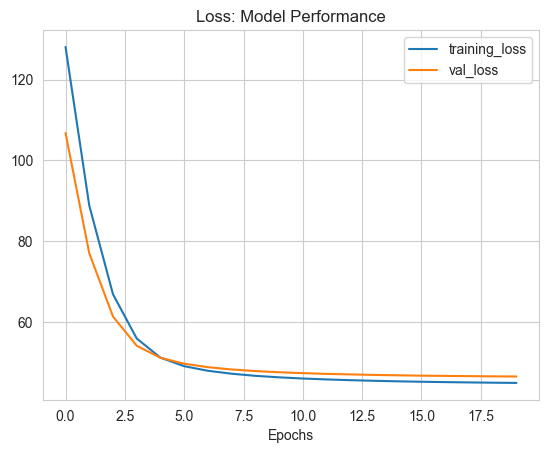

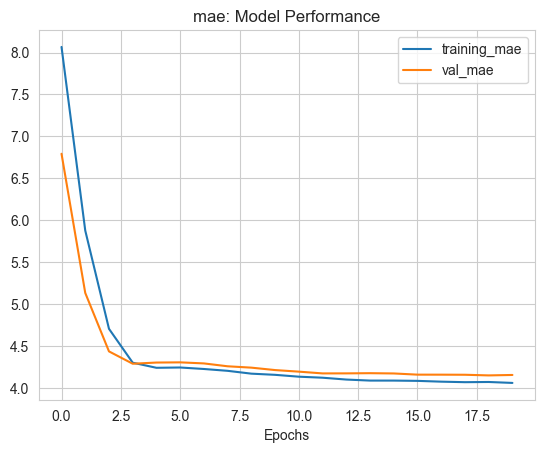

In [26]:
# tfu.plot_history_metric(history_01, title="Model Performance")
# plot_all_history_metrics(history_01, title="Model Performance")
plot_loss_and_mae(history_01, title="Model Performance")

Make model predictions for training and testing data subsets

In [27]:
y_train_pred_01 =  model_01.predict(X_train_normal)
y_test_pred_01 =  model_01.predict(X_test_normal)

328/328 [==============================] - 0s 483us/step


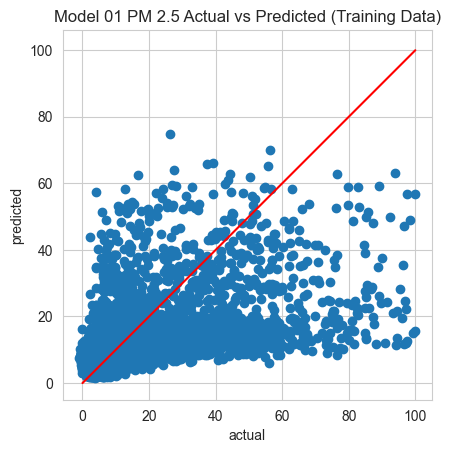

In [28]:
scatter_plot(x=y_train, 
             y=y_train_pred_01,
             title="Model 01 PM 2.5 Actual vs Predicted (Training Data)",)

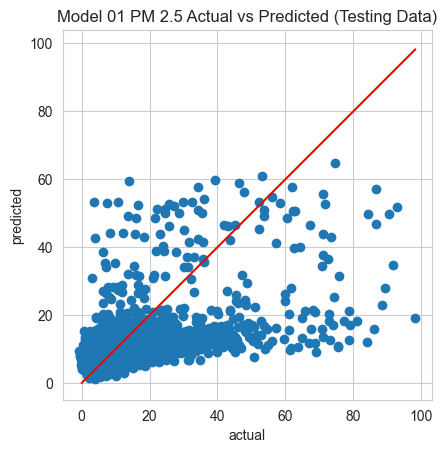

In [29]:
scatter_plot(x=y_test, 
             y=y_test_pred_01,
             title="Model 01 PM 2.5 Actual vs Predicted (Testing Data)",)

In [30]:
error_diagnostics(y_train, 
                  y_train_pred_01,
                  y_test, 
                  y_test_pred_01,
                  model_01_description)

Performance of: Model_01 Simple Single Node Model
Mean Average Error Score Training Data: 4.065641403198242
Mean Average Error Score Testing Data: 4.156088352203369
Mean Squared Error Score Training Data: 44.86530303955078
Mean Squared Error Score Testing Data: 46.517845153808594


#### Model_02: Complex Deep Neural Net
model_02 is a overly complex deep learning model

In [31]:
model_02_description = "Model_02 Overly Complex Deep Learning Model"

model_02 = keras.Sequential([
  layers.Dense(10, activation="relu"),
  layers.Dense(100, activation="relu"),
  layers.Dense(1000, activation="relu"),
  layers.Dense(10000, activation="relu"),
  layers.Dense(1, activation=None)
])

In [32]:
model_02.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer='adam',
                 metrics=['mae', 'mse'])

In [33]:
history_02 = model_02.fit(X_train_normal,
                          y_train,
                          validation_data=(X_test_normal, y_test),
                          epochs=20,
                          # verbose=0,
                          )

Epoch 1/20
1310/1310 [==============================] - 17s 13ms/step - loss: 44.5744 - mae: 4.1657 - mse: 44.5744 - val_loss: 38.7291 - val_mae: 4.0765 - val_mse: 38.7291
Epoch 2/20
1310/1310 [==============================] - 8s 6ms/step - loss: 36.4613 - mae: 3.7382 - mse: 36.4613 - val_loss: 37.3038 - val_mae: 3.5817 - val_mse: 37.3038
Epoch 3/20
1310/1310 [==============================] - 4s 3ms/step - loss: 34.3812 - mae: 3.6241 - mse: 34.3812 - val_loss: 34.7113 - val_mae: 3.6857 - val_mse: 34.7113
Epoch 4/20
1310/1310 [==============================] - 4s 3ms/step - loss: 32.5727 - mae: 3.5362 - mse: 32.5727 - val_loss: 34.7641 - val_mae: 3.6450 - val_mse: 34.7641
Epoch 5/20
1310/1310 [==============================] - 4s 3ms/step - loss: 31.9483 - mae: 3.4970 - mse: 31.9483 - val_loss: 33.5662 - val_mae: 3.6059 - val_mse: 33.5662
Epoch 6/20
1310/1310 [==============================] - 4s 3ms/step - loss: 31.4906 - mae: 3.4724 - mse: 31.4906 - val_loss: 33.3383 - val_mae: 3.53

In [34]:
plot_model_summary(model_02)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                1800      
                                                                 
 dense_2 (Dense)             (None, 100)               1100      
                                                                 
 dense_3 (Dense)             (None, 1000)              101000    
                                                                 
 dense_4 (Dense)             (None, 10000)             10010000  
                                                                 
 dense_5 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 10,123,901
Trainable params: 10,123,901
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot

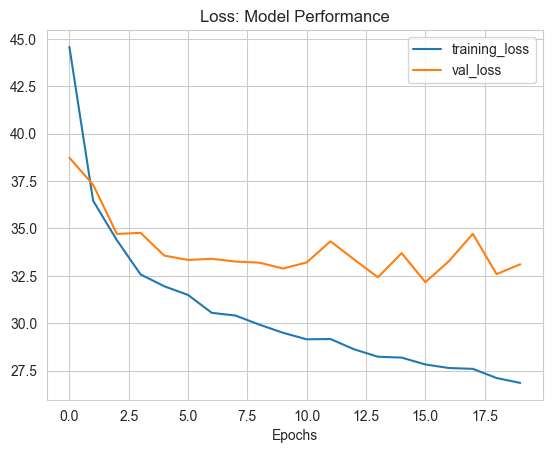

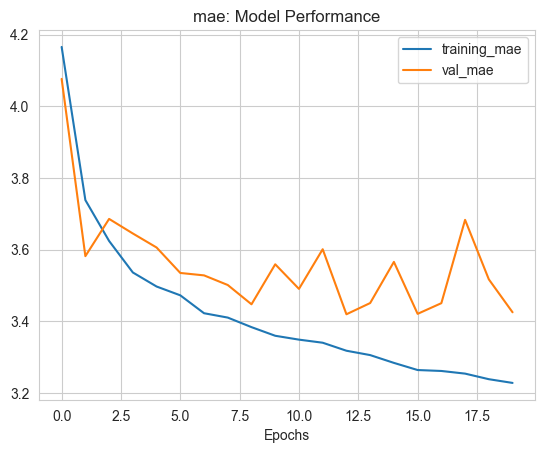

In [35]:
# tfu.plot_history_metric(history_01, title="Model Performance")
# plot_all_history_metrics(history_01, title="Model Performance")
plot_loss_and_mae(history_02, title="Model Performance")

Make model predictions for training and testing data subsets

In [36]:
y_train_pred_02 =  model_02.predict(X_train_normal)
y_test_pred_02 =  model_02.predict(X_test_normal)

328/328 [==============================] - 0s 645us/step


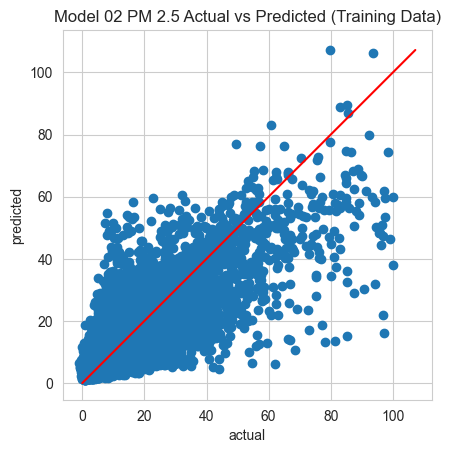

In [37]:
scatter_plot(x=y_train, 
             y=y_train_pred_02,
             title="Model 02 PM 2.5 Actual vs Predicted (Training Data)",)

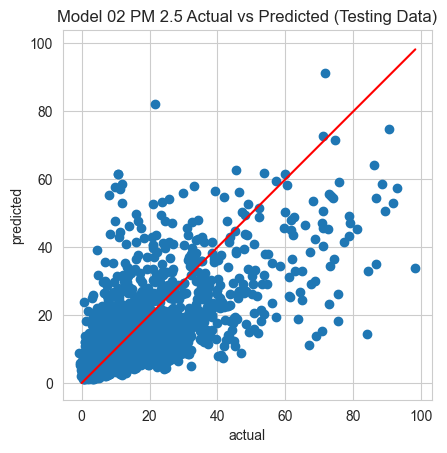

In [38]:
scatter_plot(x=y_test, 
             y=y_test_pred_02,
             title="Model 02 PM 2.5 Actual vs Predicted (Testing Data)",)

In [39]:
error_diagnostics(y_train, 
                  y_train_pred_02,
                  y_test, 
                  y_test_pred_02,
                  model_02_description)

Performance of: Model_02 Overly Complex Deep Learning Model
Mean Average Error Score Training Data: 3.133052110671997
Mean Average Error Score Testing Data: 3.4250826835632324
Mean Squared Error Score Training Data: 25.0904598236084
Mean Squared Error Score Testing Data: 33.11001205444336


#### Model_03: Goldilocks Neural Net Architecture
model_03 is a hopeful blend of parameter rich but not overly complex deep learning model

In [40]:
model_03_description = "Model_03 Compact Deep Learning Model"

model_03 = keras.Sequential([
  layers.Dense(32, activation="relu"),
  layers.Dense(16, activation="relu"),
  layers.Dense(16, activation="relu"),
  layers.Dense(1, activation=None)
])

In [41]:
model_03.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer='adam',
                 metrics=['mae', 'mse'])

In [42]:
history_03 = model_03.fit(X_train_normal,
                          y_train,
                          validation_data=(X_test_normal, y_test),
                          epochs=20,
                          # verbose=0,
                          )

Epoch 1/20
1310/1310 [==============================] - 3s 2ms/step - loss: 50.3224 - mae: 4.3632 - mse: 50.3224 - val_loss: 39.2122 - val_mae: 3.8025 - val_mse: 39.2122
Epoch 2/20
1310/1310 [==============================] - 3s 2ms/step - loss: 36.2521 - mae: 3.7243 - mse: 36.2521 - val_loss: 35.7670 - val_mae: 3.6607 - val_mse: 35.7670
Epoch 3/20
1310/1310 [==============================] - 3s 2ms/step - loss: 33.9038 - mae: 3.6070 - mse: 33.9038 - val_loss: 35.7706 - val_mae: 3.8092 - val_mse: 35.7706
Epoch 4/20
1310/1310 [==============================] - 3s 2ms/step - loss: 32.9218 - mae: 3.5480 - mse: 32.9218 - val_loss: 33.9920 - val_mae: 3.5776 - val_mse: 33.9920
Epoch 5/20
1310/1310 [==============================] - 3s 2ms/step - loss: 32.3459 - mae: 3.5092 - mse: 32.3459 - val_loss: 33.4646 - val_mae: 3.6373 - val_mse: 33.4646
Epoch 6/20
1310/1310 [==============================] - 3s 2ms/step - loss: 31.5426 - mae: 3.4655 - mse: 31.5426 - val_loss: 33.7708 - val_mae: 3.4942

In [43]:
plot_model_summary(model_03)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                5760      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,577
Trainable params: 6,577
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


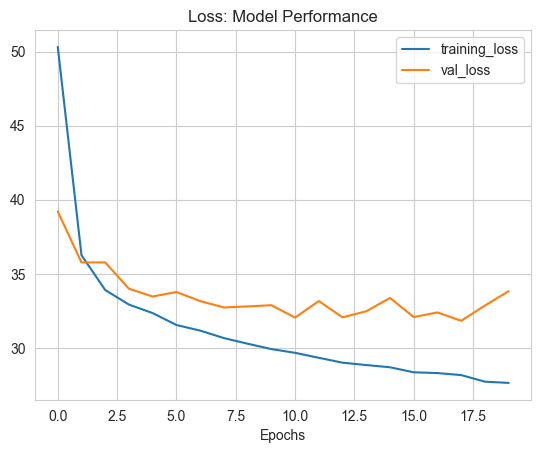

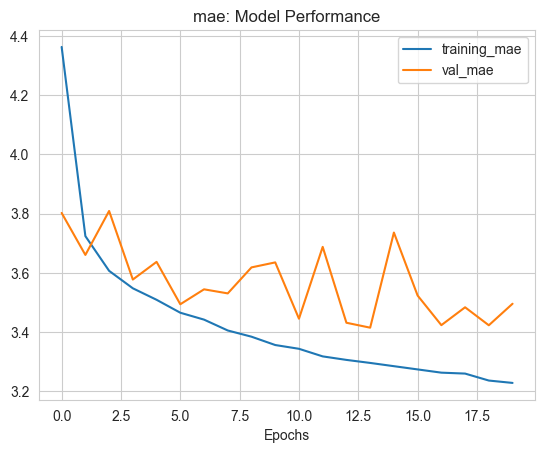

In [44]:
# tfu.plot_history_metric(history_01, title="Model Performance")
# plot_all_history_metrics(history_01, title="Model Performance")
plot_loss_and_mae(history_03, title="Model Performance")

Make model predictions for training and testing data subsets

In [45]:
y_train_pred_03 =  model_03.predict(X_train_normal)
y_test_pred_03 =  model_03.predict(X_test_normal)

328/328 [==============================] - 0s 576us/step


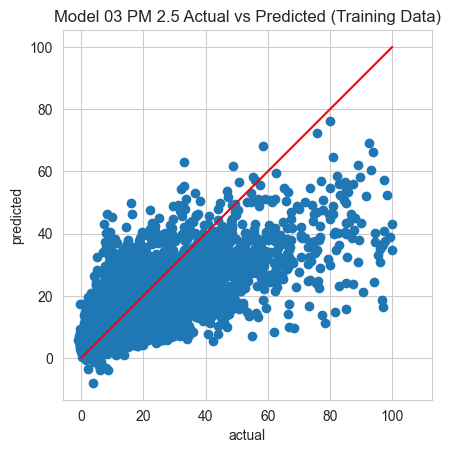

In [46]:
scatter_plot(x=y_train, 
             y=y_train_pred_03,
             title="Model 03 PM 2.5 Actual vs Predicted (Training Data)",)

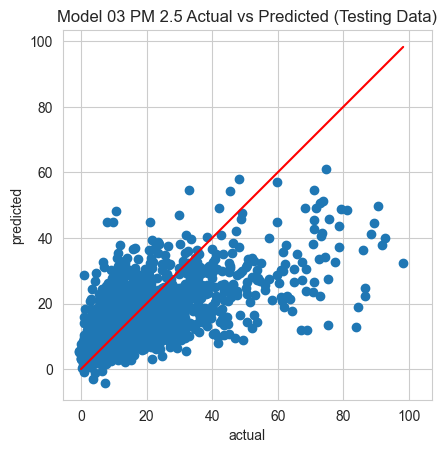

In [47]:
scatter_plot(x=y_test, 
             y=y_test_pred_03,
             title="Model 03 PM 2.5 Actual vs Predicted (Testing Data)",)

In [48]:
error_diagnostics(y_train, 
                  y_train_pred_03,
                  y_test, 
                  y_test_pred_03,
                  model_03_description)

Performance of: Model_03 Compact Deep Learning Model
Mean Average Error Score Training Data: 3.2092208862304688
Mean Average Error Score Testing Data: 3.495903968811035
Mean Squared Error Score Training Data: 27.608245849609375
Mean Squared Error Score Testing Data: 33.825897216796875
